# Portfolio Allocation

- ZHANG MIAN

## American Stock Market

First, import sp500 data and clean nan value stocks.

### Get SP500 Data

In [76]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.optimize as sco
import scipy.interpolate as sci
import random
from sklearn.isotonic import IsotonicRegression

import warnings
warnings.filterwarnings("ignore")

In [145]:
def get_sp500_data(start_date='2016-01-01', end_date='2023-04-30'):
    
    def sp500_list(): 
        url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        table = pd.read_html(url, attrs={"id": "constituents"})[0]
        symbols = table["Symbol"].tolist()
        return symbols

    def download_batch(symbols, start_date, end_date, interval='1d'):
        data = yf.download(symbols, start=start_date, end=end_date, interval=interval, progress=False)
        close_data = data.loc[:, 'Adj Close']
        close_data.columns = symbols 
        return close_data

    symbols = sp500_list()
    sp500 = pd.DataFrame()

    batch_size = 1
    for i in range(0, len(symbols), batch_size):
        batch_data = download_batch(symbols[i:i + batch_size], start_date, end_date)
        sp500 = pd.concat([sp500, batch_data], axis=1)

    sp500.columns = symbols
    cleaned_sp500 = sp500.dropna(axis=1)
    cleaned_sp500.index = pd.to_datetime(cleaned_sp500.index)

    sp500_returns = ((cleaned_sp500 - cleaned_sp500.shift(1)) / cleaned_sp500.shift(1)).dropna()
    
    return cleaned_sp500, sp500_returns

today = datetime.date.today()
sp500, sp500_returns = get_sp500_data(start_date='2016-01-01', end_date=today)


1 Failed download:
- BRK.B: No timezone found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


In [188]:
sp500_returns

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
2016-01-05,0.004359,-0.005587,-0.000233,-0.004166,0.005205,-0.012759,0.011161,0.004023,0.002437,-0.006831,...,0.006880,-0.012072,0.018904,0.010084,-0.000277,-0.002493,-0.025117,0.020823,-0.010857,0.015655
2016-01-06,-0.020141,-0.019797,-0.008388,0.000174,-0.001954,-0.009424,-0.024283,-0.014295,-0.012277,-0.026455,...,0.000000,-0.003155,-0.051805,0.010538,-0.012476,-0.007080,-0.039957,0.004330,-0.029145,0.000208
2016-01-07,-0.024362,-0.048854,-0.023966,-0.002963,-0.029366,-0.014134,-0.023756,-0.020984,-0.030519,0.011073,...,-0.086538,-0.009646,-0.094070,0.003842,-0.025828,-0.034116,-0.045316,-0.022993,-0.030020,-0.030404
2016-01-08,-0.003405,-0.035581,-0.020944,-0.027268,-0.009681,-0.015440,-0.003766,-0.014140,-0.008251,-0.021971,...,0.014528,-0.011870,-0.040704,-0.010935,-0.009510,-0.013607,-0.002693,-0.004217,-0.011254,-0.014605
2016-01-11,-0.000214,-0.025885,0.001475,-0.031806,0.010489,0.014002,-0.006688,0.017416,0.004864,0.010236,...,-0.014149,-0.029108,-0.016453,0.008016,-0.008438,-0.001761,-0.006582,-0.017233,-0.019919,-0.028335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,-0.006568,-0.005078,-0.003895,0.004998,-0.023625,0.007550,-0.060644,-0.020539,-0.017543,-0.024048,...,-0.002789,-0.005168,-0.024895,0.002112,-0.015496,-0.007847,-0.014192,0.006660,-0.054475,-0.018883
2023-04-26,-0.013893,-0.015604,-0.011094,-0.018799,0.001884,-0.114480,0.014888,-0.017668,-0.004063,-0.011714,...,-0.007596,-0.017877,-0.019529,-0.021073,-0.018850,0.001451,-0.012953,0.000144,-0.012720,-0.000462
2023-04-27,0.023416,0.015704,0.006897,-0.079914,0.015634,0.010415,0.012722,0.023027,0.025281,0.021009,...,-0.050301,0.055379,0.007035,0.008324,0.028223,0.012970,0.013194,-0.005249,0.007200,0.005840
2023-04-28,0.008450,-0.003938,0.008858,0.015114,0.017571,0.001288,0.000897,0.016531,0.017765,0.005044,...,0.025641,-0.001134,0.036835,-0.004981,0.000096,0.005579,0.013762,0.000650,0.048157,0.010520


[*********************100%***********************]  1 of 1 completed
Annualized Mean Return: 0.11630922765875132
Annualized Variance: 0.03663444430777659
Sharpe Ratio: 0.5031796815679033


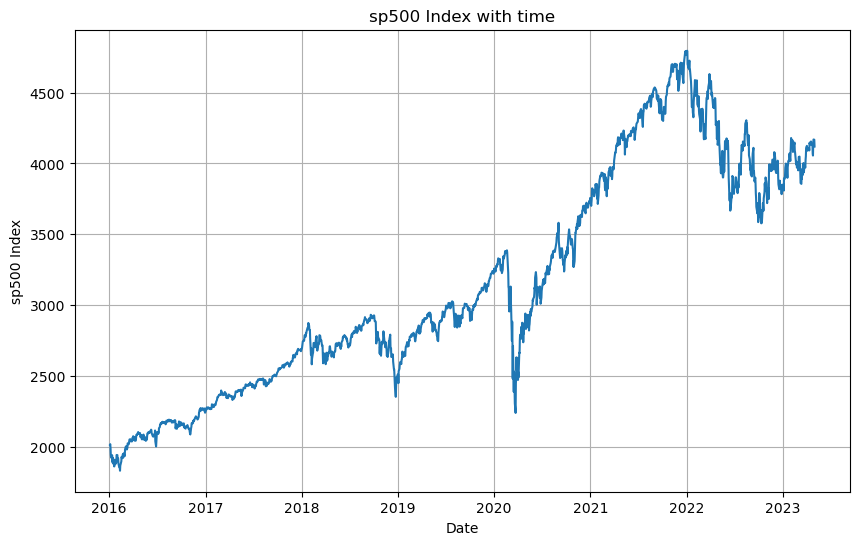

In [208]:
def get_sp500_index(start_date='2016-01-01', end_date='2023-04-30'):
    df = yf.download('^GSPC', start=start_date, end=end_date, progress=False)
    
    df['returns'] = df['Adj Close'].pct_change()

    mean_daily_return = df['returns'].mean()
    variance_daily_return = df['returns'].var()

    trading_days = 252
    annualized_mean_return = mean_daily_return * trading_days
    annualized_variance_return = variance_daily_return * trading_days

    risk_free_rate = 0.02  
    sharpe_ratio = (annualized_mean_return - risk_free_rate) / np.sqrt(annualized_variance_return)

    print(f"Annualized Mean Return: {annualized_mean_return}")
    print(f"Annualized Variance: {annualized_variance_return}")
    print(f"Sharpe Ratio: {sharpe_ratio}")

    plt.figure(figsize=(10, 6))
    plt.plot(df['Adj Close'])
    plt.xlabel('Date')
    plt.ylabel('sp500 Index')
    plt.title('sp500 Index with time')
    plt.grid(True)
    plt.show()
    
    return sp500_index

today = datetime.date.today()
sp500_index = get_sp500_index(start_date='2016-01-01', end_date=today)

In [147]:
def annually_data(sp500_returns):
    yearly_dataframes = {}

    for year, group in sp500_returns.groupby(pd.Grouper(freq='Y')):
        yearly_dataframes[year.year] = group
    return yearly_dataframes

yearly_dataframes = annually_data(sp500_returns=sp500_returns)
yearly_dataframes[2016]

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
2016-01-05,0.004359,-0.005587,-0.000233,-0.004166,0.005205,-0.012759,0.011161,0.004023,0.002437,-0.006831,...,0.006880,-0.012072,0.018904,0.010084,-0.000277,-0.002493,-0.025117,0.020823,-0.010857,0.015655
2016-01-06,-0.020141,-0.019797,-0.008388,0.000174,-0.001954,-0.009424,-0.024283,-0.014295,-0.012277,-0.026455,...,0.000000,-0.003155,-0.051805,0.010538,-0.012476,-0.007080,-0.039957,0.004330,-0.029145,0.000208
2016-01-07,-0.024362,-0.048854,-0.023966,-0.002963,-0.029366,-0.014134,-0.023756,-0.020984,-0.030519,0.011073,...,-0.086538,-0.009646,-0.094070,0.003842,-0.025828,-0.034116,-0.045316,-0.022993,-0.030020,-0.030404
2016-01-08,-0.003405,-0.035581,-0.020944,-0.027268,-0.009681,-0.015440,-0.003766,-0.014140,-0.008251,-0.021971,...,0.014528,-0.011870,-0.040704,-0.010935,-0.009510,-0.013607,-0.002693,-0.004217,-0.011254,-0.014605
2016-01-11,-0.000214,-0.025885,0.001475,-0.031806,0.010489,0.014002,-0.006688,0.017416,0.004864,0.010236,...,-0.014149,-0.029108,-0.016453,0.008016,-0.008438,-0.001761,-0.006582,-0.017233,-0.019919,-0.028335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,-0.002511,-0.001044,0.003395,0.011028,-0.002632,0.001647,-0.000664,0.002865,0.003216,0.002934,...,0.013350,-0.004744,0.001020,0.000000,-0.002347,-0.003747,0.002901,0.007384,0.002743,0.009763
2016-12-27,0.000951,0.008361,0.004685,0.002567,0.000596,0.000822,0.011074,-0.000381,0.003692,0.005559,...,-0.001687,0.004092,-0.001132,0.001475,-0.002941,0.003448,0.007290,0.008014,0.001596,-0.001116
2016-12-28,-0.004695,-0.013474,-0.009844,-0.003680,-0.007997,-0.002737,-0.006791,-0.011526,-0.002517,-0.008263,...,-0.015288,-0.017267,-0.013146,-0.010803,-0.018089,-0.004841,-0.016542,-0.000776,-0.014796,-0.005212
2016-12-29,0.001853,0.001471,0.002355,0.007387,0.003430,0.001372,0.000441,-0.000867,0.003882,-0.000821,...,-0.001716,-0.001625,0.001033,0.016133,-0.003404,-0.001412,0.003855,0.004269,-0.011322,0.003368


### The First Practice for Markowitz

In [152]:
def params_sp500(sp500_returns):
    mean_returns = yearly_dataframes[2023].mean()    ##daily return 
    cov_returns = np.cov(yearly_dataframes[2023], rowvar=False, bias=True) ## daily volatility
    return mean_returns, cov_returns

# annual return
def portfolio_returns(mean_returns, weights):
    return np.sum(mean_returns * weights) * 252

# annual vol
def portfolio_vol(cov_returns, weights):   
    return np.sqrt(252 * weights @ cov_returns @ weights.T)

def neg_sharpe_ratio(mean_returns, cov_returns, weights):
    return -portfolio_returns(mean_returns, weights) / portfolio_vol(cov_returns, weights)

def sharpe_ratio(mean_returns, cov_returns, weights):
    return portfolio_returns(mean_returns, weights) / portfolio_vol(cov_returns, weights)

mean_returns, cov_returns = params_sp500(sp500_returns=sp500_returns)


In [178]:
def max_sharpe(mean_returns=mean_returns, cov_returns=cov_returns, weights=None, range_bnds=(0,1)):
    
    if weights is None:
        num_equities = len(cov_returns)
        initial_weights = np.array(num_equities * [1. / num_equities,])
        cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1})
        bnds = tuple(range_bnds for x in range(num_equities))
        obj_sharpe = lambda x: neg_sharpe_ratio(mean_returns=mean_returns, cov_returns=cov_returns, weights=x)
        Max_sharpe_portfolio=sco.minimize(obj_sharpe, initial_weights, method='SLSQP', bounds=bnds, constraints=cons)
        res_vol = portfolio_vol(cov_returns, Max_sharpe_portfolio['x'])
        res_return = portfolio_returns(mean_returns, Max_sharpe_portfolio['x'])
        return res_return, res_vol, res_return/res_vol, Max_sharpe_portfolio

    else:
        res_vol = portfolio_vol(cov_returns, weights)
        res_return = portfolio_returns(mean_returns, weights)
        return res_return, res_vol, res_return/res_vol
    
msr = max_sharpe(mean_returns=mean_returns, cov_returns=cov_returns, range_bnds=(0,1))


In [189]:
def min_variance(mean_returns=mean_returns, cov_returns=cov_returns, weights=None, range_bnds=(0,1)):
    
    if weights is None:
        num_equities = len(cov_returns)
        initial_weights = np.array(num_equities * [1. / num_equities,])
        cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1})
        bnds = tuple(range_bnds for x in range(num_equities))
        obj_sharpe = lambda x: portfolio_vol(cov_returns=cov_returns, weights=x)
        Min_Variance_portfolio=sco.minimize(obj_sharpe, initial_weights, method='SLSQP', bounds=bnds, constraints=cons)
        res_vol = portfolio_vol(cov_returns, Min_Variance_portfolio['x'])
        res_return = portfolio_returns(mean_returns, Min_Variance_portfolio['x'])
        return res_return, res_vol, res_return/res_vol, Min_Variance_portfolio

    else:
        res_vol = portfolio_vol(cov_returns, weights)
        res_return = portfolio_returns(mean_returns, weights)
        return res_return, res_vol, res_return/res_vol
    
mvr = min_variance(mean_returns=mean_returns, cov_returns=cov_returns, range_bnds=(0,1))


In [179]:
def effieicent_frontier_in(mean_returns, cov_returns, range_bnds=(0,1), range_returns=None):
    
    if range_returns is None:
        opt_return = max_sharpe(mean_returns=mean_returns, cov_returns=cov_returns, range_bnds=(0,1))[0]
        range_returns=(0.01, opt_return*1.5)
    
    num_equities = len(cov_returns)
    initial_weights = np.array(num_equities * [1. / num_equities,])
    target_returns = np.linspace(range_returns[0], range_returns[1], 100)
    target_vols = []
    
    cons_eff = ({'type':'eq', 'fun': lambda x: portfolio_returns(mean_returns, x) - target_return},
               {'type':'eq', 'fun':lambda x: np.sum(x)-1})
    bnds_eff = tuple(range_bnds for x in range(num_equities))
    obj_eff = lambda x: portfolio_vol(cov_returns, x)
    
    weights = []
    for target_return in tqdm(target_returns):
        res = sco.minimize(obj_eff, initial_weights, method='SLSQP', bounds=bnds_eff, constraints=cons_eff)
        target_vols.append(res['fun'])
        weights.append(res['x'])
        
    return target_returns, np.array(target_vols), np.array(weights)

#efficient_frointier_data = effieicent_frontier_in(mean_returns=mean_returns, cov_returns=cov_returns, range_bnds=(0,1))
#print(efficient_frointier_data)


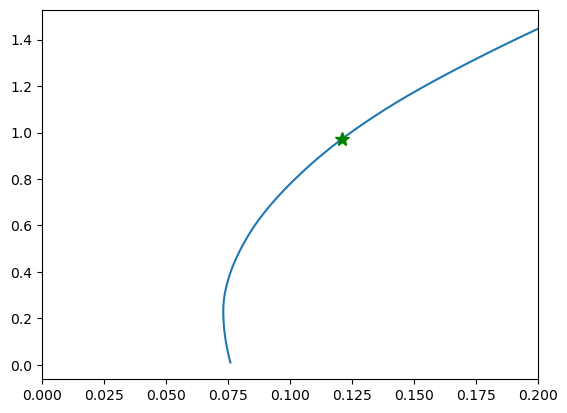

In [171]:
plt.plot(efficient_frointier_data[1], efficient_frointier_data[0])
plt.plot(msr[1], msr[0], 'g*', markersize=10)
plt.xlim(0, 0.2)
plt.show()

In [156]:
efficient_frointier_data[2][50][efficient_frointier_data[2][50]>0.01]

array([0.02961342, 0.01385738, 0.0500722 , 0.01301146, 0.04922823,
       0.02999348, 0.01642083, 0.01616639, 0.15213985, 0.0826362 ,
       0.06001383, 0.09097874, 0.04071285, 0.03979709, 0.16747317,
       0.03734173, 0.07601448])

In [158]:
sp500.iloc[:, efficient_frointier_data[2][50]>0.01]

,ABBV,CPB,CBOE,CMG,CME,EA,FDX,GE,HSY,INCY,KR,PEP,PSX,TMUS,ULTA,WST,ZBH
2016-01-04,57.610001,51.660000,63.990002,448.809998,88.669998,66.099998,143.429993,184.411224,87.989998,103.320000,41.160000,98.769997,80.080002,38.950001,181.809998,57.599998,98.844658
2016-01-05,57.369999,51.849998,63.099998,449.029999,89.370003,64.940002,144.649994,184.591370,87.669998,103.800003,42.090000,99.449997,81.000000,40.220001,182.669998,56.869999,100.902916
2016-01-06,57.380001,51.759998,62.459999,426.670013,88.930000,63.680000,140.770004,181.648956,87.730003,102.260002,42.049999,99.480003,78.029999,40.049999,183.210007,57.250000,101.339806
2016-01-07,57.209999,50.820000,62.860001,416.000000,87.529999,62.459999,134.589996,173.962646,85.699997,95.760002,41.070000,97.570000,76.449997,40.509998,182.979996,55.990002,99.009712
2016-01-08,55.650002,51.110001,62.549999,413.290009,86.230003,63.130001,134.710007,170.840088,84.919998,94.779999,40.799999,97.209999,75.209999,39.880001,182.169998,55.439999,98.592232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,164.899994,54.669998,139.100006,1780.000000,187.789993,129.500000,225.470001,98.440002,262.980011,73.550003,47.970001,189.710007,99.320000,148.000000,541.859985,357.000000,139.059998
2023-04-26,161.800003,54.540001,137.660004,2009.849976,184.929993,125.120003,222.770004,96.209999,261.750000,73.529999,47.820000,188.539993,99.269997,148.279999,547.450012,357.230011,139.080002
2023-04-27,148.869995,54.980000,138.199997,2036.260010,184.410004,126.510002,225.940002,98.059998,273.329987,73.650002,48.340000,189.690002,97.739998,149.940002,547.770020,355.220001,138.350006
2023-04-28,151.119995,54.299999,139.699997,2067.620117,185.770004,127.279999,227.779999,98.970001,273.059998,74.410004,48.630001,190.889999,99.000000,143.899994,551.429993,361.239990,138.440002


In [9]:
efficient_frointier_data[2][50][efficient_frointier_data[2][50]>0.03]


array([0.03864621, 0.12606259, 0.06115277, 0.05964398, 0.07324247,
       0.05604041, 0.05001398, 0.04822827, 0.05825986, 0.08094559,
       0.26136043])

In [12]:
sp500.iloc[:, efficient_frointier_data[2][50]>0.03]


,ABBV,ATVI,AMGN,CPB,XOM,FSLR,GIS,K,LMT,MCK,MRK
2016-01-04,57.610001,37.619999,158.339996,51.660000,77.459999,66.720001,57.459999,71.610001,213.210007,194.669998,50.076336
2016-01-05,57.369999,37.139999,158.169998,51.849998,78.120003,72.029999,57.200001,71.870003,218.259995,195.500000,50.715649
2016-01-06,57.380001,36.790001,156.720001,51.759998,77.470001,69.519997,56.730000,72.010002,217.630005,193.100006,50.019085
2016-01-07,57.209999,36.270000,152.979996,50.820000,76.230003,66.220001,55.110001,70.370003,213.289993,187.809998,49.580154
2016-01-08,55.650002,35.709999,150.710007,51.110001,74.690002,65.620003,55.290001,71.480003,212.910004,182.389999,48.740459
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,164.080002,86.089996,244.449997,53.490002,118.199997,209.899994,87.620003,67.620003,480.920013,361.920013,115.940002
2023-04-25,164.899994,86.739998,244.869995,54.669998,116.519997,210.529999,88.500000,68.550003,475.579987,363.290009,116.529999
2023-04-26,161.800003,76.809998,238.800003,54.540001,115.449997,199.509995,87.879997,68.459999,461.619995,359.239990,113.430000
2023-04-27,148.869995,77.610001,240.339996,54.980000,116.830002,200.830002,88.790001,69.290001,465.000000,363.809998,115.160004


In [160]:
def efficient_frontier_out(mean_returns, cov_returns, weights):
    returns_out = 252 * weights @ mean_returns
    vol_out = np.sqrt(252 * (weights @ cov_returns @ weights.T).diagonal())
    return returns_out, vol_out

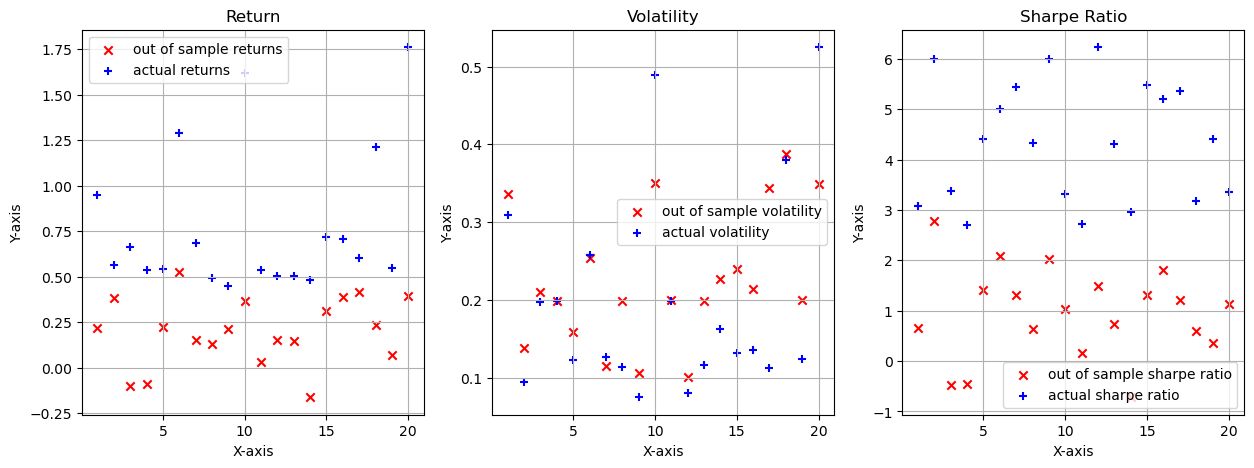

In [186]:
def simulate_max_sharpe_ratios_strats(sp500, num_trials=20, window_size=252, horizon=30):
    in_sample_sharpe_ratios = []
    actual_sharpe_ratios = []
    
    for _ in range(num_trials):

        start_idx = np.random.randint(0, len(sp500) - window_size - horizon)
        in_sample_data = sp500[start_idx : start_idx + window_size]
        out_of_sample_data = sp500[start_idx + window_size : start_idx + window_size + horizon]

        in_sample_returns = np.diff(in_sample_data, axis=0) / in_sample_data[:-1]
        out_of_sample_returns = np.diff(out_of_sample_data, axis=0) / out_of_sample_data[:-1]

        mean_returns_in = np.mean(in_sample_returns, axis=0)
        cov_returns_in = np.cov(in_sample_returns, rowvar=False, bias=True)
        mean_returns_out = np.mean(out_of_sample_returns, axis=0)
        cov_returns_out = np.cov(out_of_sample_returns, rowvar=False, bias=True)

        in_sample_weight = max_sharpe(mean_returns=mean_returns_in, cov_returns=cov_returns_in, weights=None, range_bnds=(0,1))[-1]['x']
        in_sample_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=in_sample_weight)
        actual_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=None)

        in_sample_sharpe_ratios.append(in_sample_sharpe)
        actual_sharpe_ratios.append(actual_sharpe)
        
    in_sample_sharpe_ratios = np.array(in_sample_sharpe_ratios)
    actual_sharpe_ratios = np.array(actual_sharpe_ratios)
    x = np.arange(1, num_trials + 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 0], label='out of sample returns', color='r', marker='x')
    ax1.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 0], label='actual returns', color='b', marker='+')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    ax1.set_title('Return')
    ax1.legend()
    ax1.grid()

    ax2.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 1], label='out of sample volatility', color='r', marker='x')
    ax2.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 1], label='actual volatility', color='b', marker='+')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_title('Volatility')
    ax2.legend()
    ax2.grid()

    ax3.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 2], label='out of sample sharpe ratio', color='r', marker='x')
    ax3.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 2], label='actual sharpe ratio', color='b', marker='+')
    ax3.set_xlabel('X-axis')
    ax3.set_ylabel('Y-axis')
    ax3.set_title('Sharpe Ratio')
    ax3.legend()
    ax3.grid()

    
    return

simulate_max_sharpe_ratios_strats(sp500=sp500, num_trials=20, window_size=252, horizon=252)



<div style="border: 1px solid black; padding: 10px;">
From the chart above:
    
    - The estimation of the return is very unstable. 
    
    - The estimation of the variance is a little unstable. 
    
    - The difference of the sharpe-ratio is mainly driven by estimation of the return.
</div>


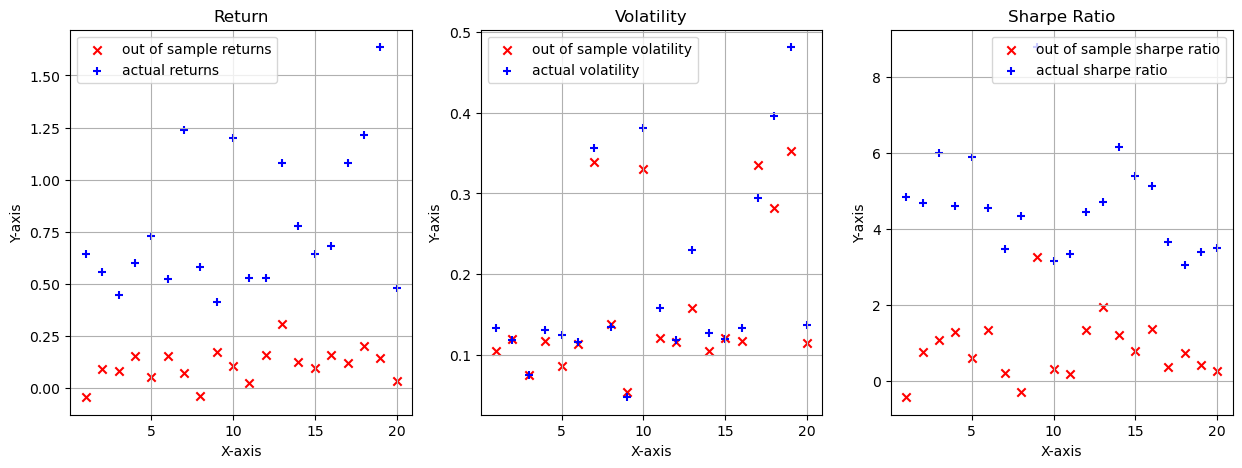

In [193]:
def simulate_min_variance_strats(sp500, num_trials=20, window_size=252, horizon=30):
    in_sample_sharpe_ratios = []
    actual_sharpe_ratios = []
    
    for _ in range(num_trials):

        start_idx = np.random.randint(0, len(sp500) - window_size - horizon)
        in_sample_data = sp500[start_idx : start_idx + window_size]
        out_of_sample_data = sp500[start_idx + window_size : start_idx + window_size + horizon]

        in_sample_returns = np.diff(in_sample_data, axis=0) / in_sample_data[:-1]
        out_of_sample_returns = np.diff(out_of_sample_data, axis=0) / out_of_sample_data[:-1]

        mean_returns_in = np.mean(in_sample_returns, axis=0)
        cov_returns_in = np.cov(in_sample_returns, rowvar=False, bias=True)
        mean_returns_out = np.mean(out_of_sample_returns, axis=0)
        cov_returns_out = np.cov(out_of_sample_returns, rowvar=False, bias=True)

        in_sample_weight = min_variance(mean_returns=mean_returns_in, cov_returns=cov_returns_in, weights=None, range_bnds=(0,1))[-1]['x']
        in_sample_sharpe = min_variance(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=in_sample_weight)
        actual_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=None)

        in_sample_sharpe_ratios.append(in_sample_sharpe)
        actual_sharpe_ratios.append(actual_sharpe)
        
    in_sample_sharpe_ratios = np.array(in_sample_sharpe_ratios)
    actual_sharpe_ratios = np.array(actual_sharpe_ratios)
    x = np.arange(1, num_trials + 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 0], label='out of sample returns', color='r', marker='x')
    ax1.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 0], label='actual returns', color='b', marker='+')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    ax1.set_title('Return')
    ax1.legend()
    ax1.grid()

    ax2.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 1], label='out of sample volatility', color='r', marker='x')
    ax2.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 1], label='actual volatility', color='b', marker='+')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_title('Volatility')
    ax2.legend()
    ax2.grid()

    ax3.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 2], label='out of sample sharpe ratio', color='r', marker='x')
    ax3.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 2], label='actual sharpe ratio', color='b', marker='+')
    ax3.set_xlabel('X-axis')
    ax3.set_ylabel('Y-axis')
    ax3.set_title('Sharpe Ratio')
    ax3.legend()
    ax3.grid()

    return

simulate_min_variance_strats(sp500=sp500, num_trials=20, window_size=252, horizon=252)



In [151]:
def backtest_cum_returns(returns, weights, initial_funds = 100000):
    daily_portfolio_returns = (returns * weights).sum(axis=1)
    cumulative_returns = (1 + daily_portfolio_returns).cumprod()
    cumulative_funds = initial_funds * cumulative_returns
    
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_funds)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Portfolio Cumulative Returns')
    plt.grid()
    plt.show()

    return daily_portfolio_returns, cumulative_returns

backtest_cum_returns(returns=sp500_returns, weights=efficient_frointier_data[2][60], initial_funds=100000)

ValueError: Unable to coerce to Series, length must be 482: given 483

### Eigenvalue Clipping

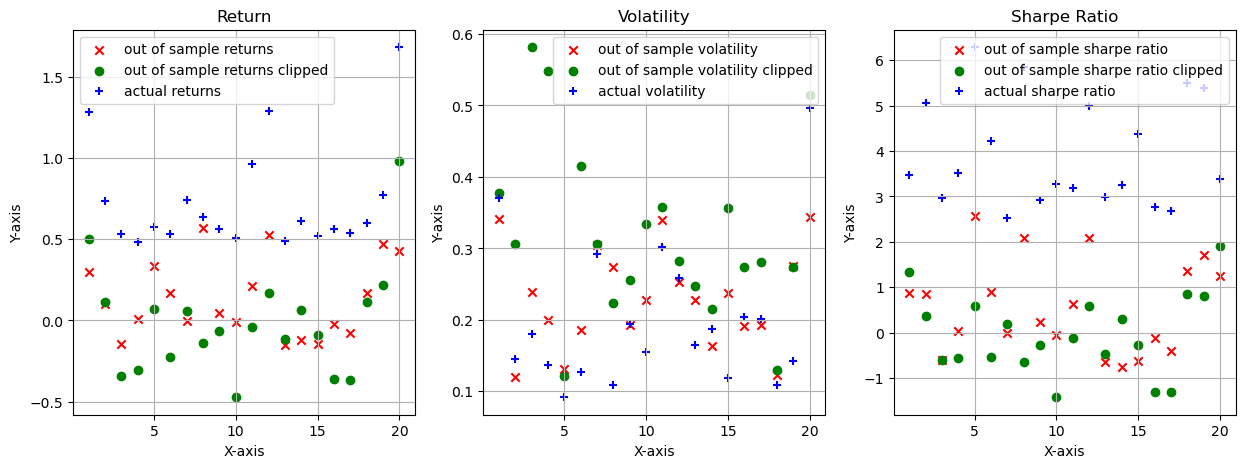

In [254]:
def eigenvalue_clipping(eigenvalues, n):
    if n > len(eigenvalues):
        raise ValueError("n should be less than or equal to the length of eigenvalues")
    
    sorted_indices = np.argsort(eigenvalues)[::-1]  # 降序排列特征值的索引
    modified_eigenvalues = np.zeros_like(eigenvalues)  # 创建一个与输入特征值相同形状的全零数组

    for i in range(n):
        modified_eigenvalues[sorted_indices[i]] = eigenvalues[sorted_indices[i]]

    return modified_eigenvalues

def eigenvalue_clipped_matrix(cov_matrix, n):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # 计算特征值和特征向量
    modified_eigenvalues = eigenvalue_clipping(eigenvalues, n)  # 调用之前编写的函数

    # 构建对角矩阵，其中对角线上的元素为处理后的特征值
    modified_eigenvalue_matrix = np.diag(modified_eigenvalues)

    # 重新构建协方差矩阵
    new_cov_matrix = eigenvectors @ modified_eigenvalue_matrix @ eigenvectors.T

    return new_cov_matrix

def simulate_max_sharpe_eigenvalue_clipped_strats(sp500, num_trials=20, window_size=252, horizon=30, nums_keeped=1):
    in_sample_sharpe_ratios = []
    in_sample_sharpe_ratios_c = []
    actual_sharpe_ratios = []
    
    for _ in range(num_trials):

        start_idx = np.random.randint(0, len(sp500) - window_size - horizon)
        in_sample_data = sp500[start_idx : start_idx + window_size]
        out_of_sample_data = sp500[start_idx + window_size : start_idx + window_size + horizon]

        in_sample_returns = np.diff(in_sample_data, axis=0) / in_sample_data[:-1]
        out_of_sample_returns = np.diff(out_of_sample_data, axis=0) / out_of_sample_data[:-1]

        mean_returns_in = np.mean(in_sample_returns, axis=0)
        cov_returns_in = np.cov(in_sample_returns, rowvar=False, bias=True)
        cov_returns_in_clipped = eigenvalue_clipped_matrix(cov_returns_in, n=nums_keeped)
        mean_returns_out = np.mean(out_of_sample_returns, axis=0)
        cov_returns_out = np.cov(out_of_sample_returns, rowvar=False, bias=True)
        
        in_sample_weight = max_sharpe(mean_returns=mean_returns_in, cov_returns=cov_returns_in, weights=None, range_bnds=(0,1))[-1]['x']
        in_sample_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=in_sample_weight)
        in_sample_weight_c = max_sharpe(mean_returns=mean_returns_in, cov_returns=cov_returns_in_clipped, weights=None, range_bnds=(0,1))[-1]['x']
        in_sample_sharpe_c = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=in_sample_weight_c)
        actual_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=None)

        in_sample_sharpe_ratios.append(in_sample_sharpe)
        in_sample_sharpe_ratios_c.append(in_sample_sharpe_c)
        actual_sharpe_ratios.append(actual_sharpe)
        
    in_sample_sharpe_ratios = np.array(in_sample_sharpe_ratios)
    in_sample_sharpe_ratios_c = np.array(in_sample_sharpe_ratios_c)
    actual_sharpe_ratios = np.array(actual_sharpe_ratios)
    x = np.arange(1, num_trials + 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 0], label='out of sample returns', color='r', marker='x')
    ax1.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_c[:, 0], label='out of sample returns clipped', color='green', marker='o')
    ax1.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 0], label='actual returns', color='b', marker='+')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    ax1.set_title('Return')
    ax1.legend()
    ax1.grid()

    ax2.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 1], label='out of sample volatility', color='r', marker='x')
    ax2.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_c[:, 1], label='out of sample volatility clipped', color='green', marker='o')
    ax2.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 1], label='actual volatility', color='b', marker='+')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_title('Volatility')
    ax2.legend()
    ax2.grid()

    ax3.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 2], label='out of sample sharpe ratio', color='r', marker='x')
    ax3.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_c[:, 2], label='out of sample sharpe ratio clipped', color='green', marker='o')
    ax3.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 2], label='actual sharpe ratio', color='b', marker='+')
    ax3.set_xlabel('X-axis')
    ax3.set_ylabel('Y-axis')
    ax3.set_title('Sharpe Ratio')
    ax3.legend()
    ax3.grid()

    return

simulate_max_sharpe_eigenvalue_clipped_strats(sp500=sp500, num_trials=20, window_size=252, horizon=252,  nums_keeped=1)



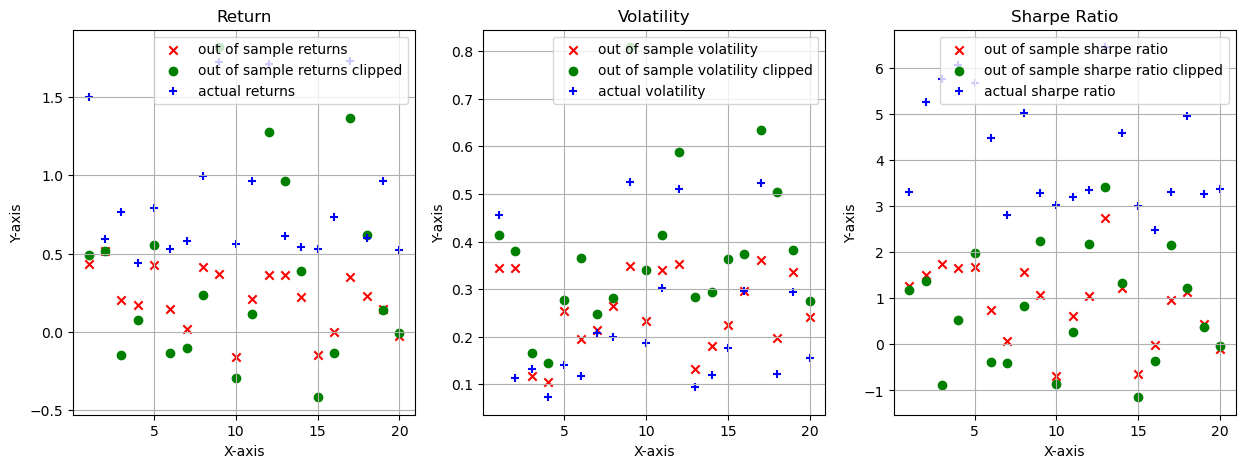

In [255]:
# Here keep three most important factors
simulate_max_sharpe_eigenvalue_clipped_strats(sp500=sp500, num_trials=20, window_size=252, horizon=252,  nums_keeped=3)


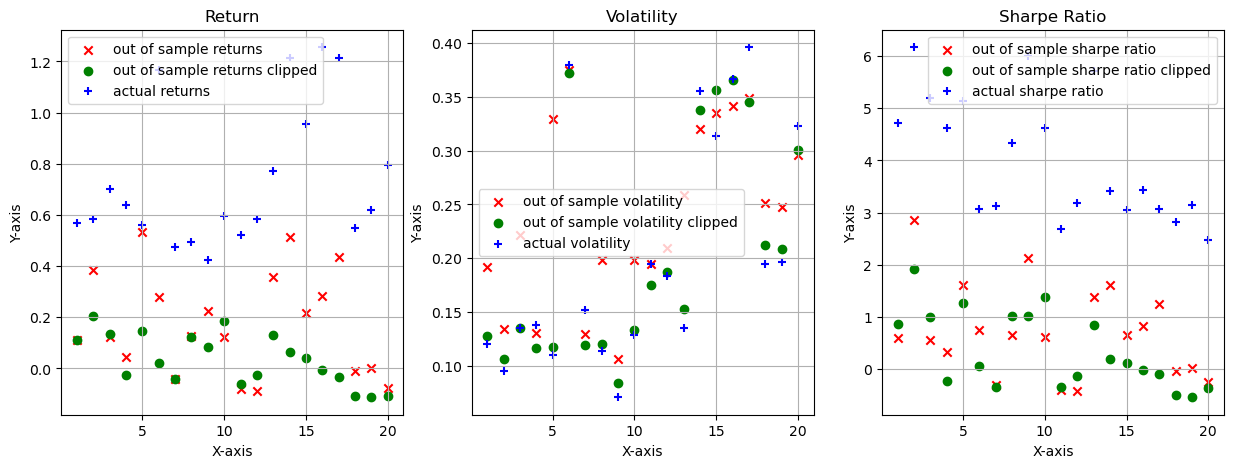

In [252]:
def eigenvalue_clipping2(eigenvalues, n):
    if n > len(eigenvalues):
        raise ValueError("n should be less than or equal to the length of eigenvalues")
    
    sorted_indices = np.argsort(eigenvalues)[::-1]  # 降序排列特征值的索引
    modified_eigenvalues = np.copy(eigenvalues)  # 创建一个与输入特征值相同的数组副本

    avg_value = np.mean(eigenvalues[n:])  # 计算剩余特征值的平均值
    for i in range(n, len(eigenvalues)):
        modified_eigenvalues[sorted_indices[i]] = avg_value

    return modified_eigenvalues

def eigenvalue_clipped_matrix2(cov_matrix, n):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # 计算特征值和特征向量
    modified_eigenvalues = eigenvalue_clipping2(eigenvalues, n)  # 调用之前编写的函数

    # 构建对角矩阵，其中对角线上的元素为处理后的特征值
    modified_eigenvalue_matrix = np.diag(modified_eigenvalues)

    # 重新构建协方差矩阵
    new_c_matrix = eigenvectors @ modified_eigenvalue_matrix @ eigenvectors.T
    diagonal_c_elements = np.diag(new_c_matrix)
    new_c_matrix = new_c_matrix / np.outer(diagonal_c_elements, diagonal_c_elements)
    
    diagonal_cov_elements = np.diag(cov_matrix)
    new_cov_matrix = new_c_matrix * np.outer(diagonal_cov_elements, diagonal_cov_elements)

    return new_cov_matrix

def simulate_max_sharpe_eigenvalue_clipped_strats2(sp500, num_trials=20, window_size=252, horizon=30, nums_keeped=1):
    in_sample_sharpe_ratios = []
    in_sample_sharpe_ratios_c = []
    actual_sharpe_ratios = []
    
    for _ in range(num_trials):

        start_idx = np.random.randint(0, len(sp500) - window_size - horizon)
        in_sample_data = sp500[start_idx : start_idx + window_size]
        out_of_sample_data = sp500[start_idx + window_size : start_idx + window_size + horizon]

        in_sample_returns = np.diff(in_sample_data, axis=0) / in_sample_data[:-1]
        out_of_sample_returns = np.diff(out_of_sample_data, axis=0) / out_of_sample_data[:-1]

        mean_returns_in = np.mean(in_sample_returns, axis=0)
        cov_returns_in = np.cov(in_sample_returns, rowvar=False, bias=True)
        cov_returns_in_clipped = eigenvalue_clipped_matrix2(cov_returns_in, n=nums_keeped)
        mean_returns_out = np.mean(out_of_sample_returns, axis=0)
        cov_returns_out = np.cov(out_of_sample_returns, rowvar=False, bias=True)

        in_sample_weight_c = max_sharpe(mean_returns=mean_returns_in, cov_returns=cov_returns_in_clipped, weights=None, range_bnds=(0,1))[-1]['x']
        in_sample_sharpe_c = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=in_sample_weight_c)
        in_sample_weight = max_sharpe(mean_returns=mean_returns_in, cov_returns=cov_returns_in, weights=None, range_bnds=(0,1))[-1]['x']
        in_sample_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=in_sample_weight)
        actual_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=None)

        in_sample_sharpe_ratios.append(in_sample_sharpe)
        in_sample_sharpe_ratios_c.append(in_sample_sharpe_c)
        actual_sharpe_ratios.append(actual_sharpe)
        
    in_sample_sharpe_ratios = np.array(in_sample_sharpe_ratios)
    in_sample_sharpe_ratios_c = np.array(in_sample_sharpe_ratios_c)
    actual_sharpe_ratios = np.array(actual_sharpe_ratios)
    x = np.arange(1, num_trials + 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 0], label='out of sample returns', color='r', marker='x')
    ax1.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_c[:, 0], label='out of sample returns clipped', color='green', marker='o')
    ax1.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 0], label='actual returns', color='b', marker='+')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    ax1.set_title('Return')
    ax1.legend()
    ax1.grid()

    ax2.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 1], label='out of sample volatility', color='r', marker='x')
    ax2.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_c[:, 1], label='out of sample volatility clipped', color='green', marker='o')
    ax2.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 1], label='actual volatility', color='b', marker='+')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_title('Volatility')
    ax2.legend()
    ax2.grid()

    ax3.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 2], label='out of sample sharpe ratio', color='r', marker='x')
    ax3.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_c[:, 2], label='out of sample sharpe ratio clipped', color='green', marker='o')
    ax3.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 2], label='actual sharpe ratio', color='b', marker='+')
    ax3.set_xlabel('X-axis')
    ax3.set_ylabel('Y-axis')
    ax3.set_title('Sharpe Ratio')
    ax3.legend()
    ax3.grid()

    return

simulate_max_sharpe_eigenvalue_clipped_strats2(sp500=sp500, num_trials=20, window_size=252, horizon=252,  nums_keeped=1)


### Cross-Validation Oracle Estimator

In [214]:
def CVshrink(data_in, iters = 100):
    len_star_out = max(10, len(data_in)//10) 
    index_in = list(data_in.index)
    Lambda_cv_list = []
    
    for j in range (0, iters):
        # Split randomly the in_sample into in_sample* and out_sample*
        index_star_out = sorted(random.sample(index_in, k = len_star_out))
        index_star_in = [i for i in index_in if i not in index_star_out]
        in_star = data_in.loc[index_star_in,:].copy()
        out_star = data_in.loc[index_star_out,:].copy()
    
        # Compute the covariances 
        sigma_in_star = np.cov(in_star, rowvar = False, bias = True)
        sigma_out_star = np.cov(out_star, rowvar = False, bias = True)
        
        # Compute Lambda_CV_j^t
        V_in_star = np.linalg.eigh(sigma_in_star)[1]
        Lambda_cv_j = (V_in_star.transpose() @ sigma_out_star @ V_in_star).diagonal()
        Lambda_cv_list.append(Lambda_cv_j)
    
    Lambda_cv = np.array(Lambda_cv_list).mean(axis = 0)
    
    # Compute Lambda_CV^ISO
    ir = IsotonicRegression()
    Lambda_cv_ISO = ir.fit_transform(np.arange(1, len(Lambda_cv) + 1), Lambda_cv)
    
    # Compute Sigma_CV
    V_in = np.linalg.eigh(np.cov(data_in, rowvar = False, bias = True))[1]
    Sigma_cv = V_in @ np.diag(Lambda_cv_ISO) @ V_in.transpose()
    
    return Lambda_cv, Lambda_cv_ISO, Sigma_cv


lambda_cv, lambda_cv_iso, sp500_in_cov_cv = CVshrink(sp500_returns)



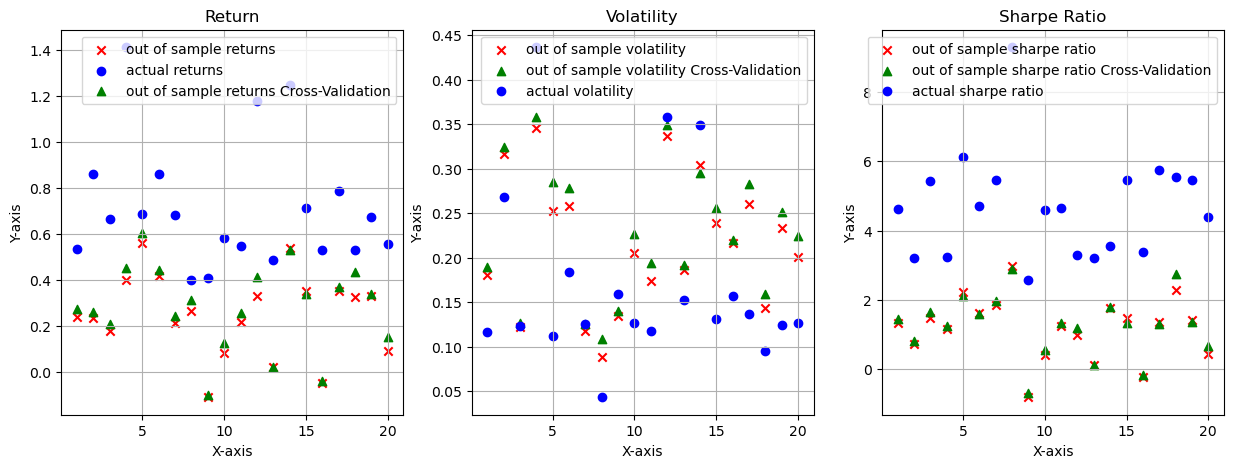

In [249]:
def simulate_max_sharpe_cross_validation_oracle(sp500, num_trials=20, window_size=252, horizon=30, nums_keeped=1):
    in_sample_sharpe_ratios_cv = []
    in_sample_sharpe_ratios = []
    actual_sharpe_ratios = []
    
    for _ in range(num_trials):

        start_idx = np.random.randint(0, len(sp500) - window_size - horizon)
        in_sample_data = sp500[start_idx : start_idx + window_size]
        out_of_sample_data = sp500[start_idx + window_size : start_idx + window_size + horizon]

        in_sample_returns = np.diff(in_sample_data, axis=0) / in_sample_data[:-1]
        out_of_sample_returns = np.diff(out_of_sample_data, axis=0) / out_of_sample_data[:-1]
        
        mean_returns_in = np.mean(in_sample_returns, axis=0)
        cov_returns_in = np.cov(in_sample_returns, rowvar=False, bias=True)
        cov_returns_in_cv = CVshrink(in_sample_returns, iters = 100)[2]
        mean_returns_out = np.mean(out_of_sample_returns, axis=0)
        cov_returns_out = np.cov(out_of_sample_returns, rowvar=False, bias=True)
        
        in_sample_weight = max_sharpe(mean_returns=mean_returns_in, cov_returns=cov_returns_in, weights=None, range_bnds=(0,1))[-1]['x']
        in_sample_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=in_sample_weight)
        in_sample_weight_cv = max_sharpe(mean_returns=mean_returns_in, cov_returns=cov_returns_in_cv, weights=None, range_bnds=(0,1))[-1]['x']
        in_sample_sharpe_cv = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=in_sample_weight_cv)
        actual_sharpe = max_sharpe(mean_returns=mean_returns_out, cov_returns=cov_returns_out, weights=None)

        in_sample_sharpe_ratios_cv.append(in_sample_sharpe_cv)
        in_sample_sharpe_ratios.append(in_sample_sharpe)
        actual_sharpe_ratios.append(actual_sharpe)
        
    in_sample_sharpe_ratios = np.array(in_sample_sharpe_ratios)
    in_sample_sharpe_ratios_cv = np.array(in_sample_sharpe_ratios_cv)
    actual_sharpe_ratios = np.array(actual_sharpe_ratios)
    x = np.arange(1, num_trials + 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 0], label='out of sample returns', color='r', marker='x')
    ax1.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 0], label='actual returns', color='b', marker='o')
    ax1.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_cv[:, 0], label='out of sample returns Cross-Validation', color='green', marker='^')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    ax1.set_title('Return')
    ax1.legend()
    ax1.grid()

    ax2.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 1], label='out of sample volatility', color='r', marker='x')
    ax2.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_cv[:, 1], label='out of sample volatility Cross-Validation', color='green', marker='^')
    ax2.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 1], label='actual volatility', color='b', marker='o')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_title('Volatility')
    ax2.legend()
    ax2.grid()

    ax3.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios[:, 2], label='out of sample sharpe ratio', color='r', marker='x')
    ax3.scatter(np.arange(1, num_trials + 1), in_sample_sharpe_ratios_cv[:, 2], label='out of sample sharpe ratio Cross-Validation', color='green', marker='^')
    ax3.scatter(np.arange(1, num_trials + 1), actual_sharpe_ratios[:, 2], label='actual sharpe ratio', color='b', marker='o')
    ax3.set_xlabel('X-axis')
    ax3.set_ylabel('Y-axis')
    ax3.set_title('Sharpe Ratio')
    ax3.legend()
    ax3.grid()

    return

simulate_max_sharpe_cross_validation_oracle(sp500=sp500, num_trials=20, window_size=252, horizon=252,  nums_keeped=1)



### K_Means for the Industries Analysis

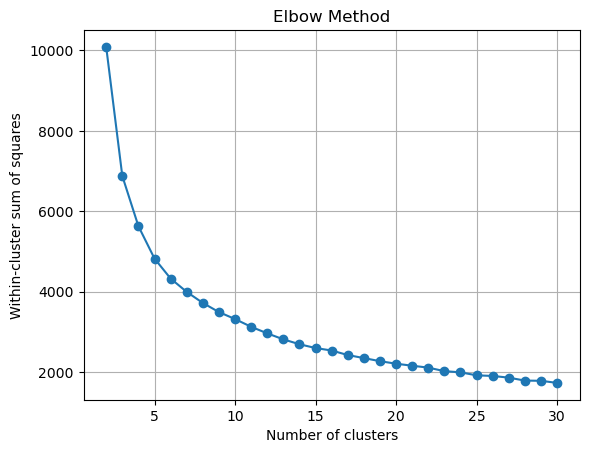

In [120]:
corr_sp500 = sp500.corr()
distance_matrix = np.sqrt(2 * (1 - corr_sp500))

min_clusters = 2
max_clusters = 30

# 计算每个簇数量的聚类误差（簇内平方和）
wcss = []
for i in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(distance_matrix)
    wcss.append(kmeans.inertia_)

# 绘制肘部法则图
plt.plot(range(min_clusters, max_clusters + 1), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method')
plt.grid()
plt.show()


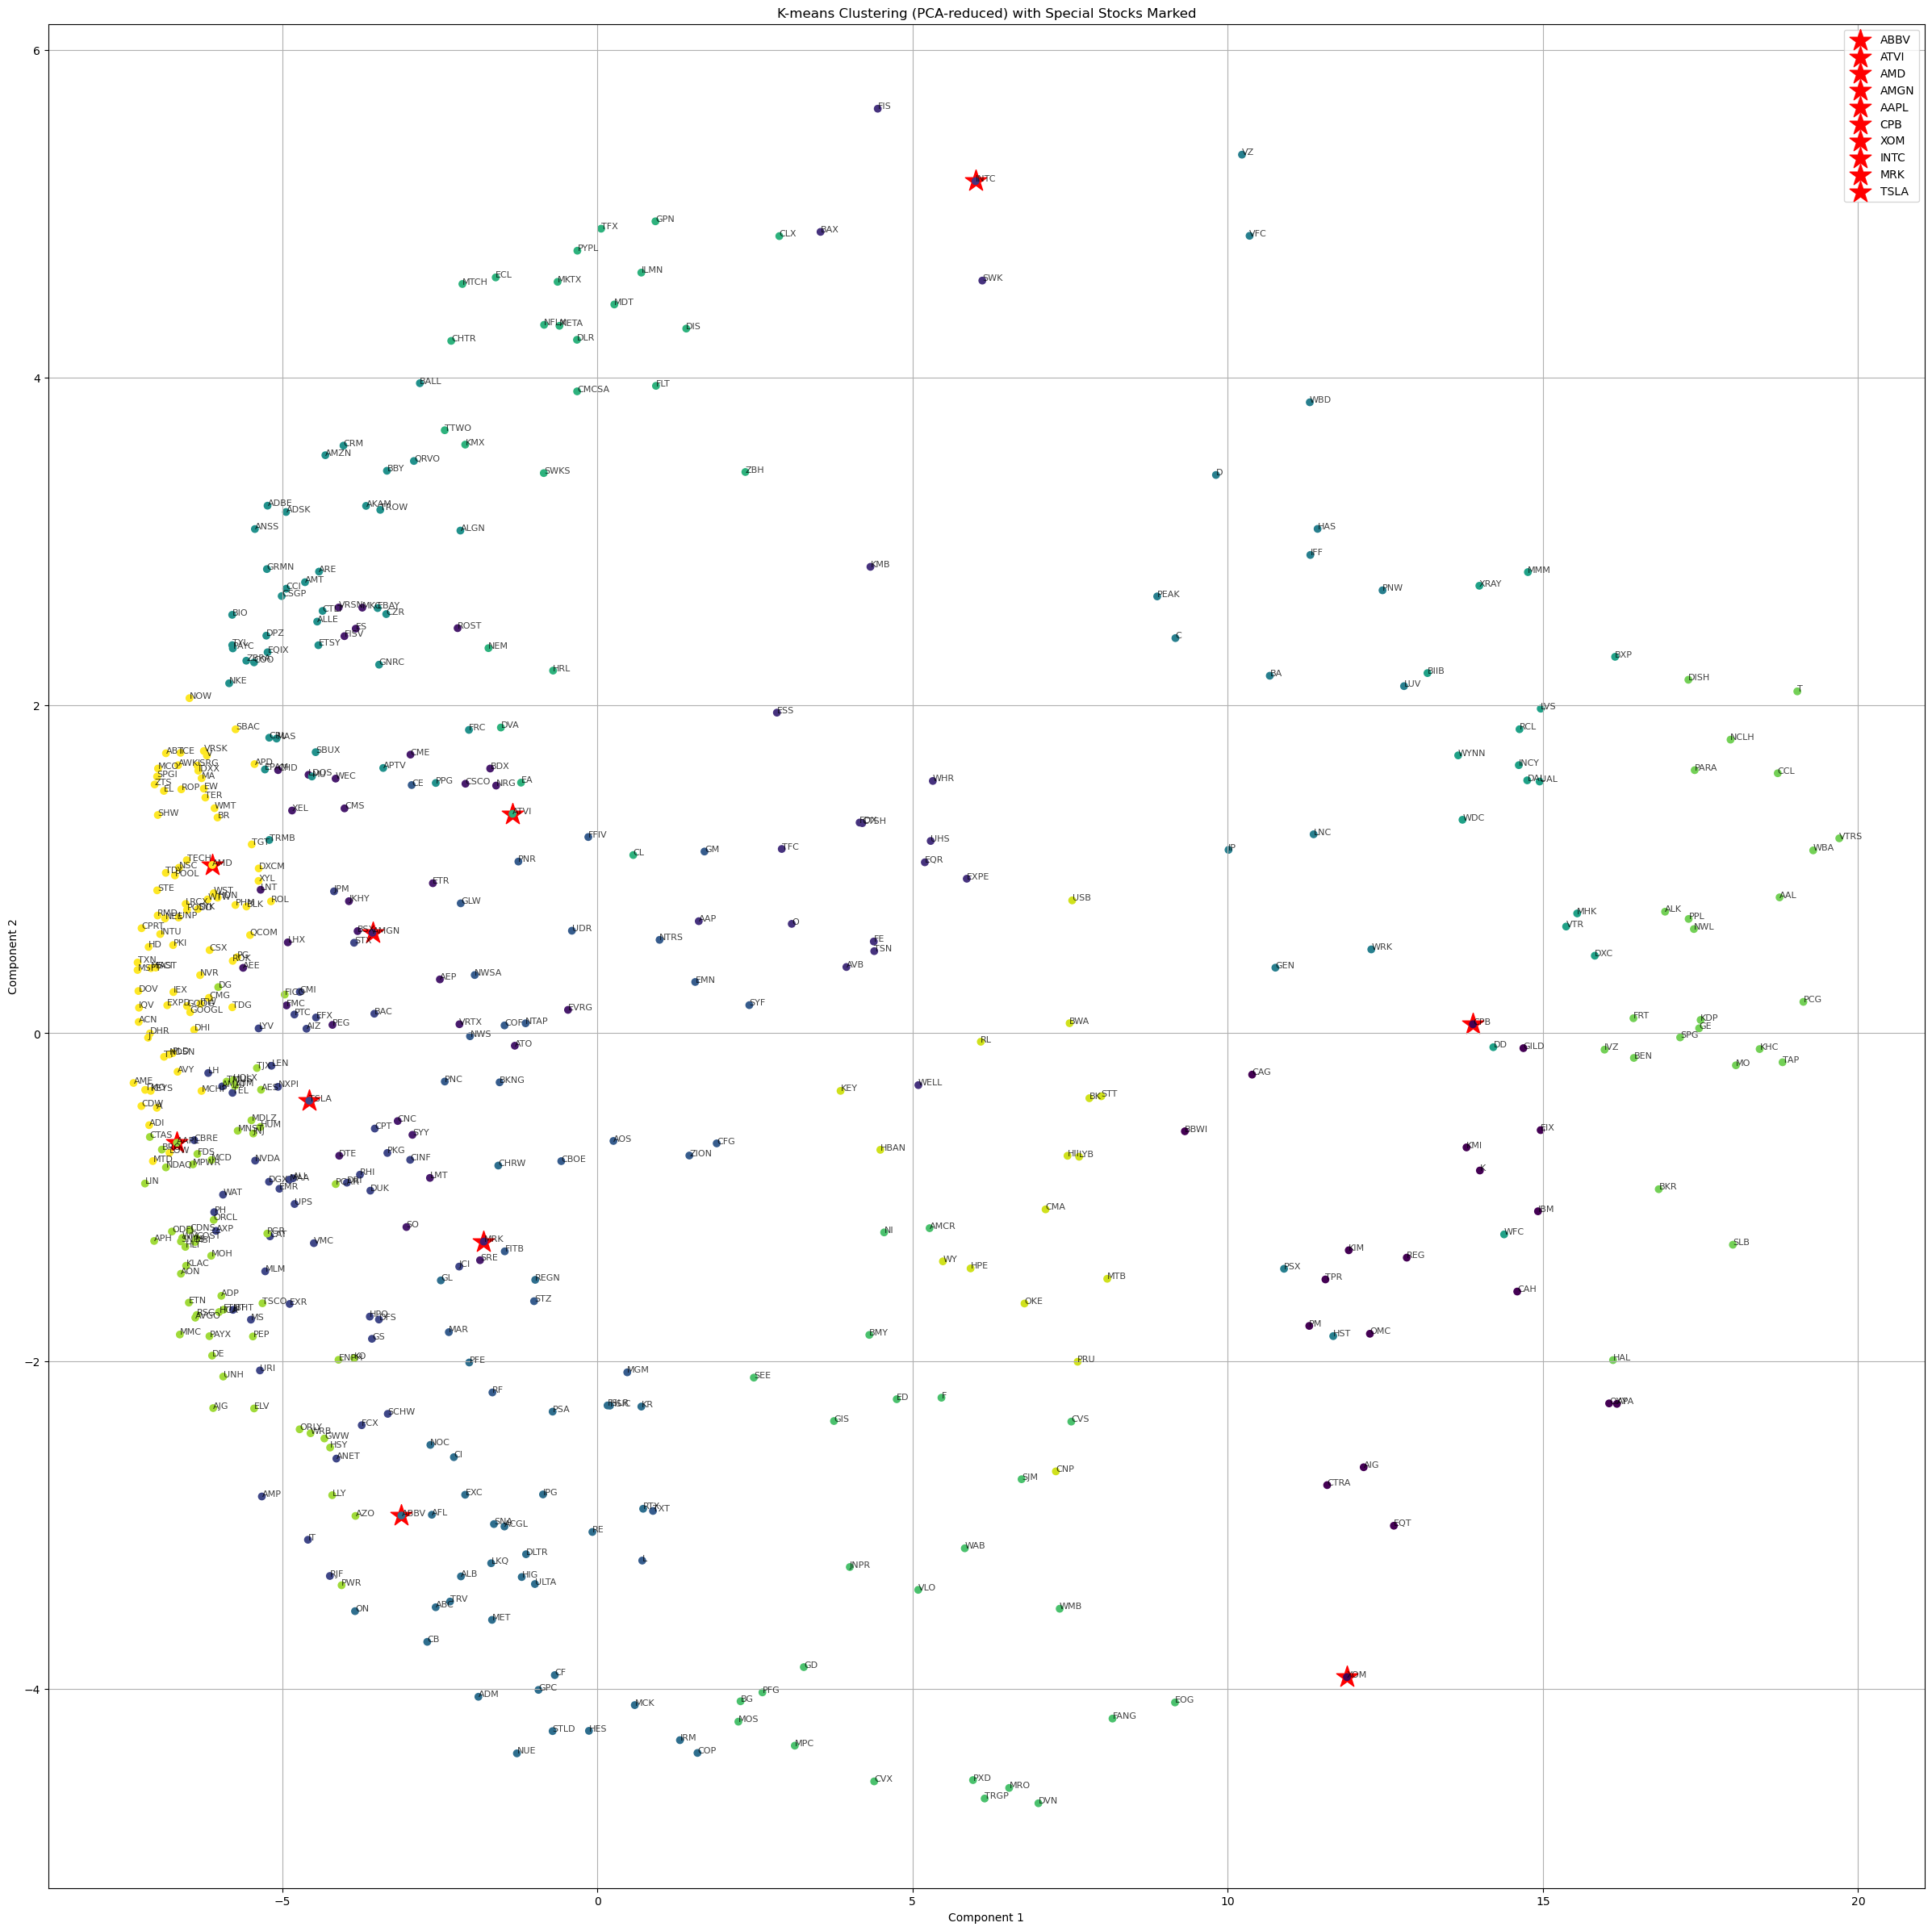

In [124]:
from sklearn.decomposition import PCA

def kmeans_sp500_PCA(sp500):
    corr_sp500 = sp500.corr()
    distance_matrix = np.sqrt(2 * (1 - corr_sp500))
    num_clusters = 15
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(distance_matrix)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(distance_matrix)

    fig, ax = plt.subplots(figsize=(30, 30))
    special_stocks = ['AAPL', 'TSLA', 'ABBV', 'MRK', 'ATVI', 'CPB', 'AMD', 'INTC', 'XOM', 'AMGN']

    for i, stock in enumerate(sp500.columns):
        if stock in special_stocks:
            ax.scatter(reduced_data[i, 0], reduced_data[i, 1], c='r', marker='*', s=400, label=stock)

    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
    stock_labels = sp500.columns
    for i, stock in enumerate(stock_labels):
        ax.annotate(stock, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=8, alpha=0.75)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('K-means Clustering (PCA-reduced) with Special Stocks Marked')
    plt.legend()
    plt.grid()
    plt.show()
    return

kmeans_sp500_PCA(sp500=sp500)

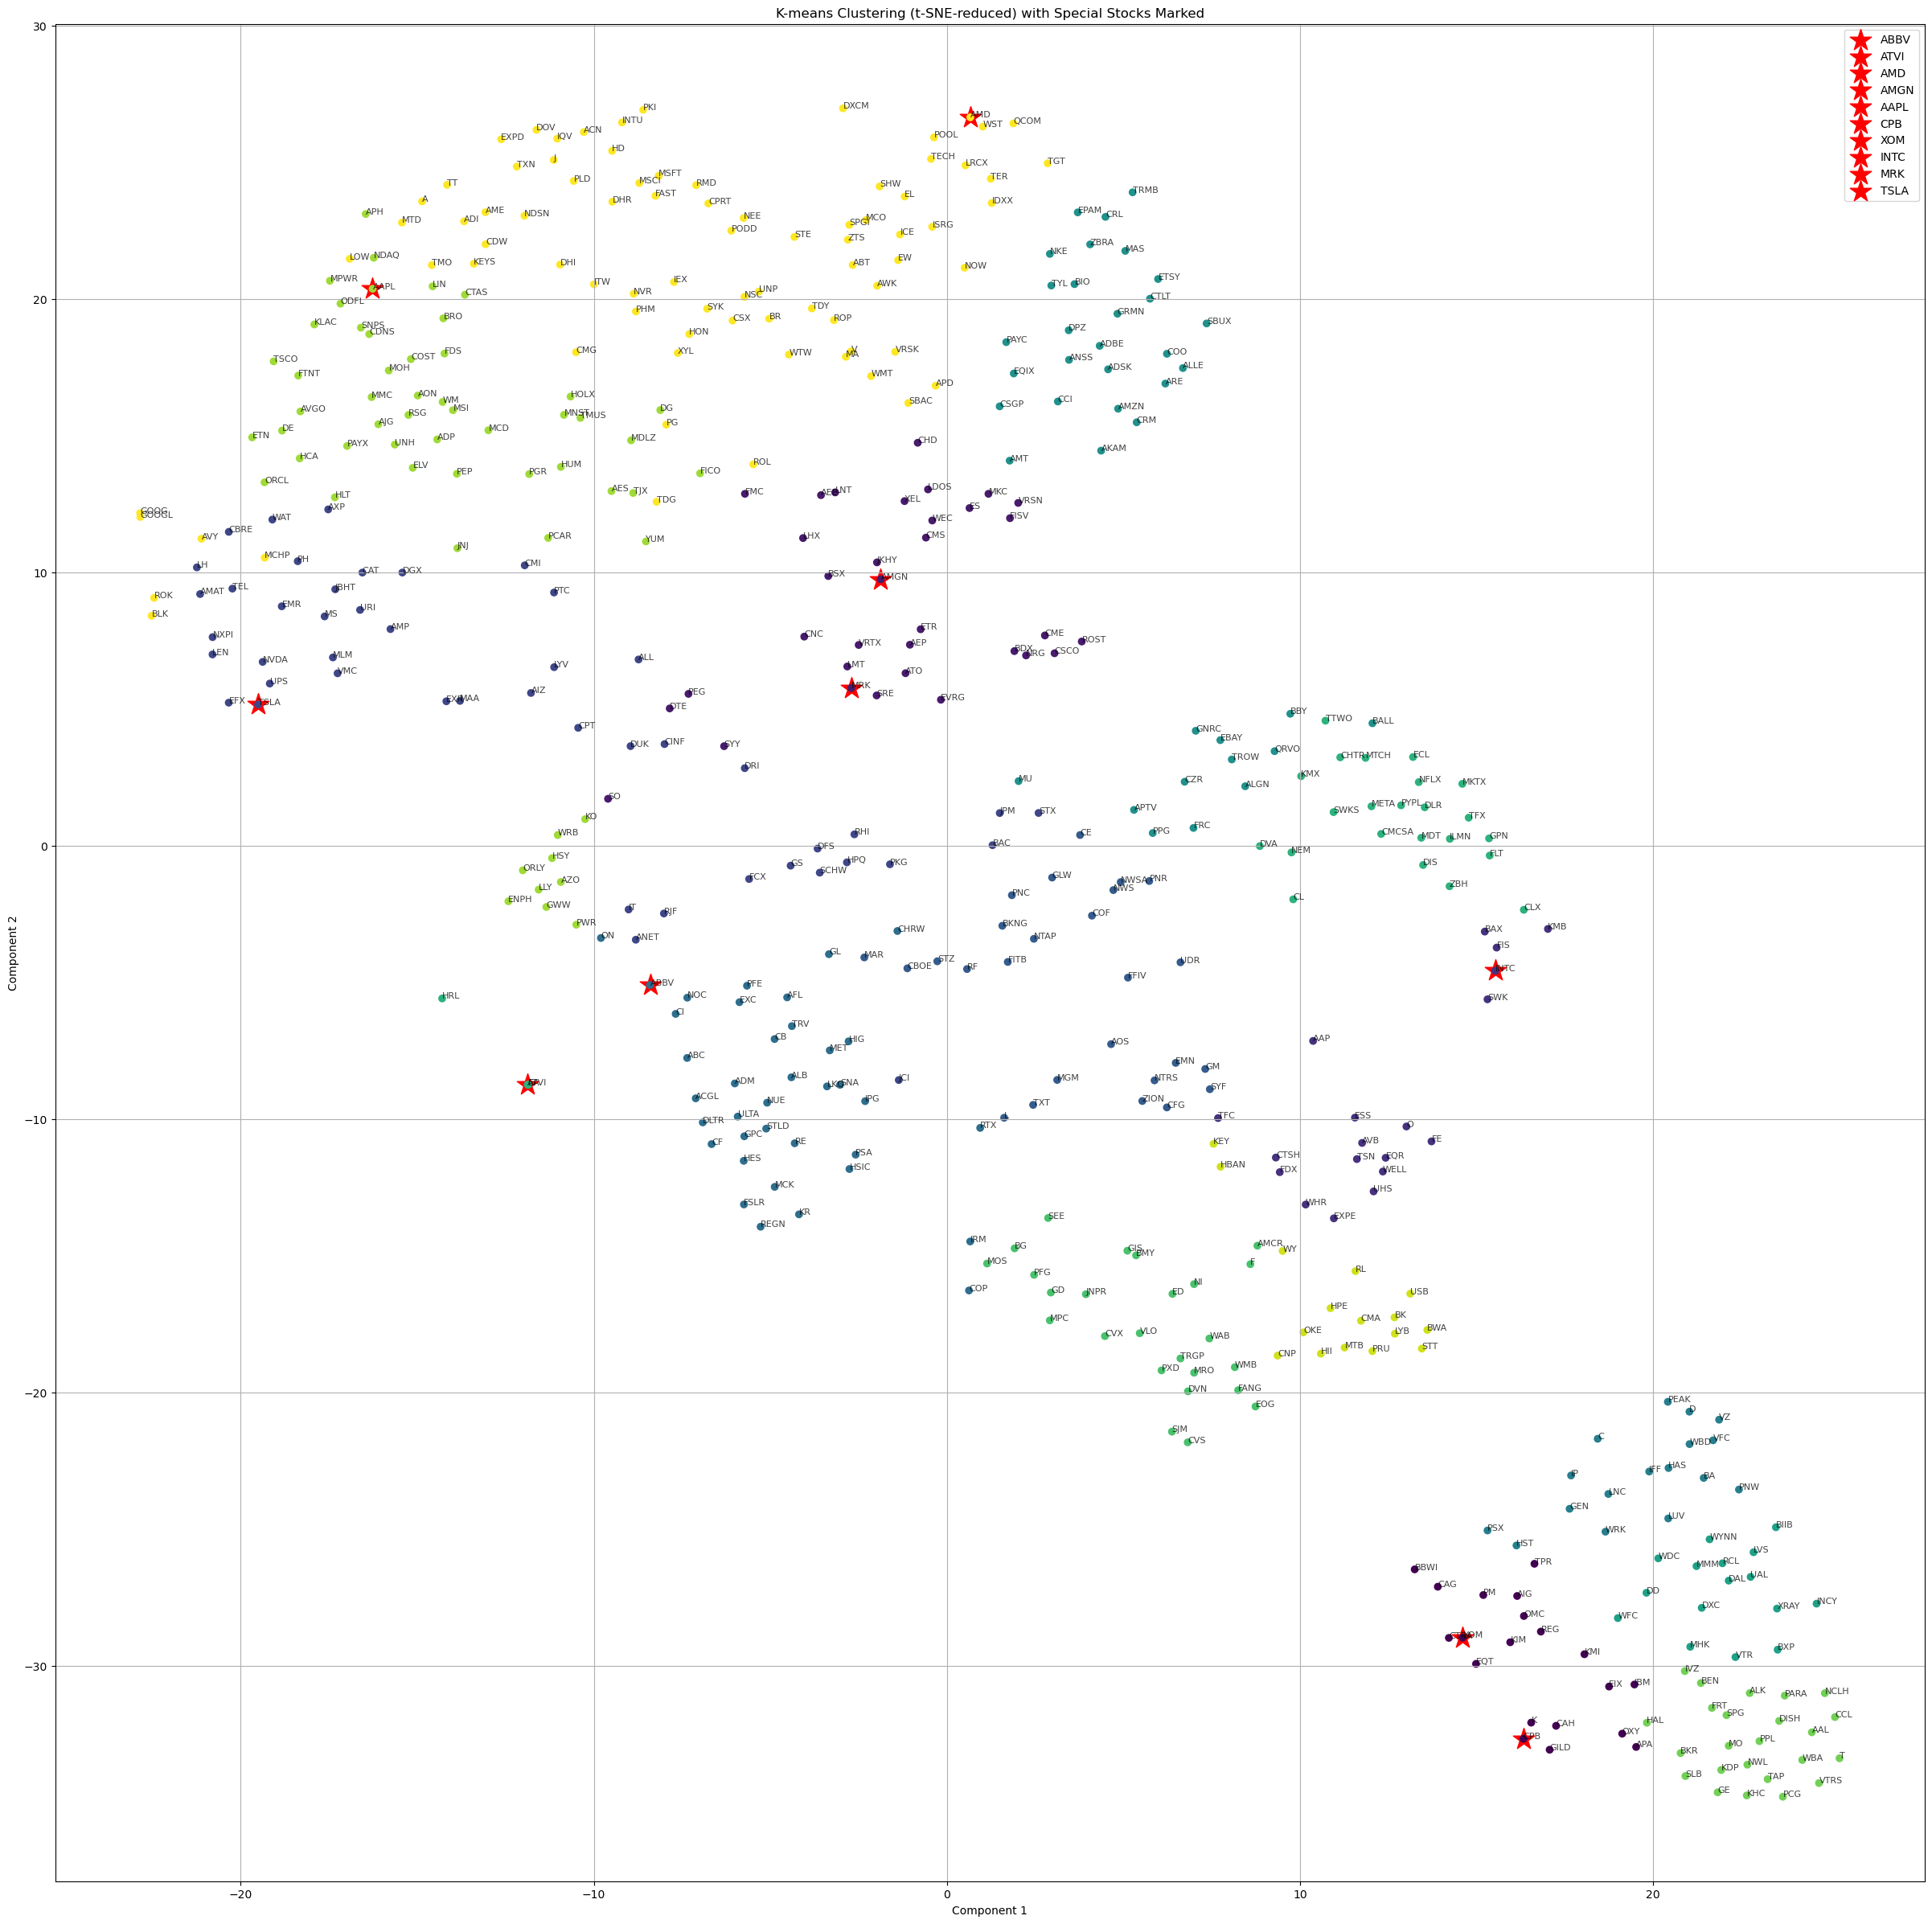

In [122]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

def kmeans_sp500_tSNE(sp500):
    corr_sp500 = sp500.corr()
    distance_matrix = np.sqrt(2 * (1 - corr_sp500))
    num_clusters = 15
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(distance_matrix)

    #sp500['cluster'] = kmeans.labels_

    tsne = TSNE(n_components=2)
    reduced_data = tsne.fit_transform(distance_matrix)

    fig, ax = plt.subplots(figsize=(30, 30))
    special_stocks = ['AAPL', 'TSLA','ABBV','MRK', 'ATVI', 'CPB','AMD', 'INTC','XOM', 'AMGN']

    for i, stock in enumerate(sp500.columns):
        if stock in special_stocks:
            ax.scatter(reduced_data[i, 0], reduced_data[i, 1], c='r', marker='*', s=400, label=stock)

    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
    stock_labels = sp500.columns
    for i, stock in enumerate(stock_labels):
        ax.annotate(stock, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=8, alpha=0.75)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('K-means Clustering (t-SNE-reduced) with Special Stocks Marked')
    plt.legend()
    plt.grid()
    plt.show()
    return

kmeans_sp500_tSNE(sp500=sp500)


### AutoEncoder for Dimension Reduction

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

corr_sp500 = sp500_returns.corr()
#normalized_corr_matrix = (corr_sp500 + 1) / 2

input_dim = corr_sp500.shape[1]
encoding_dim = 2
learning_rate = 0.003
epochs = 2000
batch_size = 16

data_tensor = torch.tensor(corr_sp500.values, dtype=torch.float32)
dataset = TensorDataset(data_tensor)
random_sampler = RandomSampler(dataset)
data_loader = DataLoader(dataset, batch_size=batch_size, sampler=random_sampler)

autoencoder = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)


for epoch in range(epochs):      
    for batch in data_loader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Learning Rate: {learning_rate:.6f}")

with torch.no_grad():
    encoded_data = autoencoder.encoder(data_tensor)
    reduced_data = encoded_data.numpy()

Epoch [100/2000], Loss: 0.0157, Learning Rate: 0.003000
Epoch [200/2000], Loss: 0.0149, Learning Rate: 0.003000
Epoch [300/2000], Loss: 0.0114, Learning Rate: 0.003000
Epoch [400/2000], Loss: 0.0116, Learning Rate: 0.003000
Epoch [500/2000], Loss: 0.0111, Learning Rate: 0.003000
Epoch [600/2000], Loss: 0.0066, Learning Rate: 0.003000
Epoch [700/2000], Loss: 0.0118, Learning Rate: 0.003000
Epoch [800/2000], Loss: 0.0081, Learning Rate: 0.003000
Epoch [900/2000], Loss: 0.0094, Learning Rate: 0.003000
Epoch [1000/2000], Loss: 0.0071, Learning Rate: 0.003000
Epoch [1100/2000], Loss: 0.0078, Learning Rate: 0.003000
Epoch [1200/2000], Loss: 0.0091, Learning Rate: 0.003000
Epoch [1300/2000], Loss: 0.0066, Learning Rate: 0.003000
Epoch [1400/2000], Loss: 0.0082, Learning Rate: 0.003000
Epoch [1500/2000], Loss: 0.0072, Learning Rate: 0.003000
Epoch [1600/2000], Loss: 0.0086, Learning Rate: 0.003000
Epoch [1700/2000], Loss: 0.0077, Learning Rate: 0.003000
Epoch [1800/2000], Loss: 0.0083, Learnin

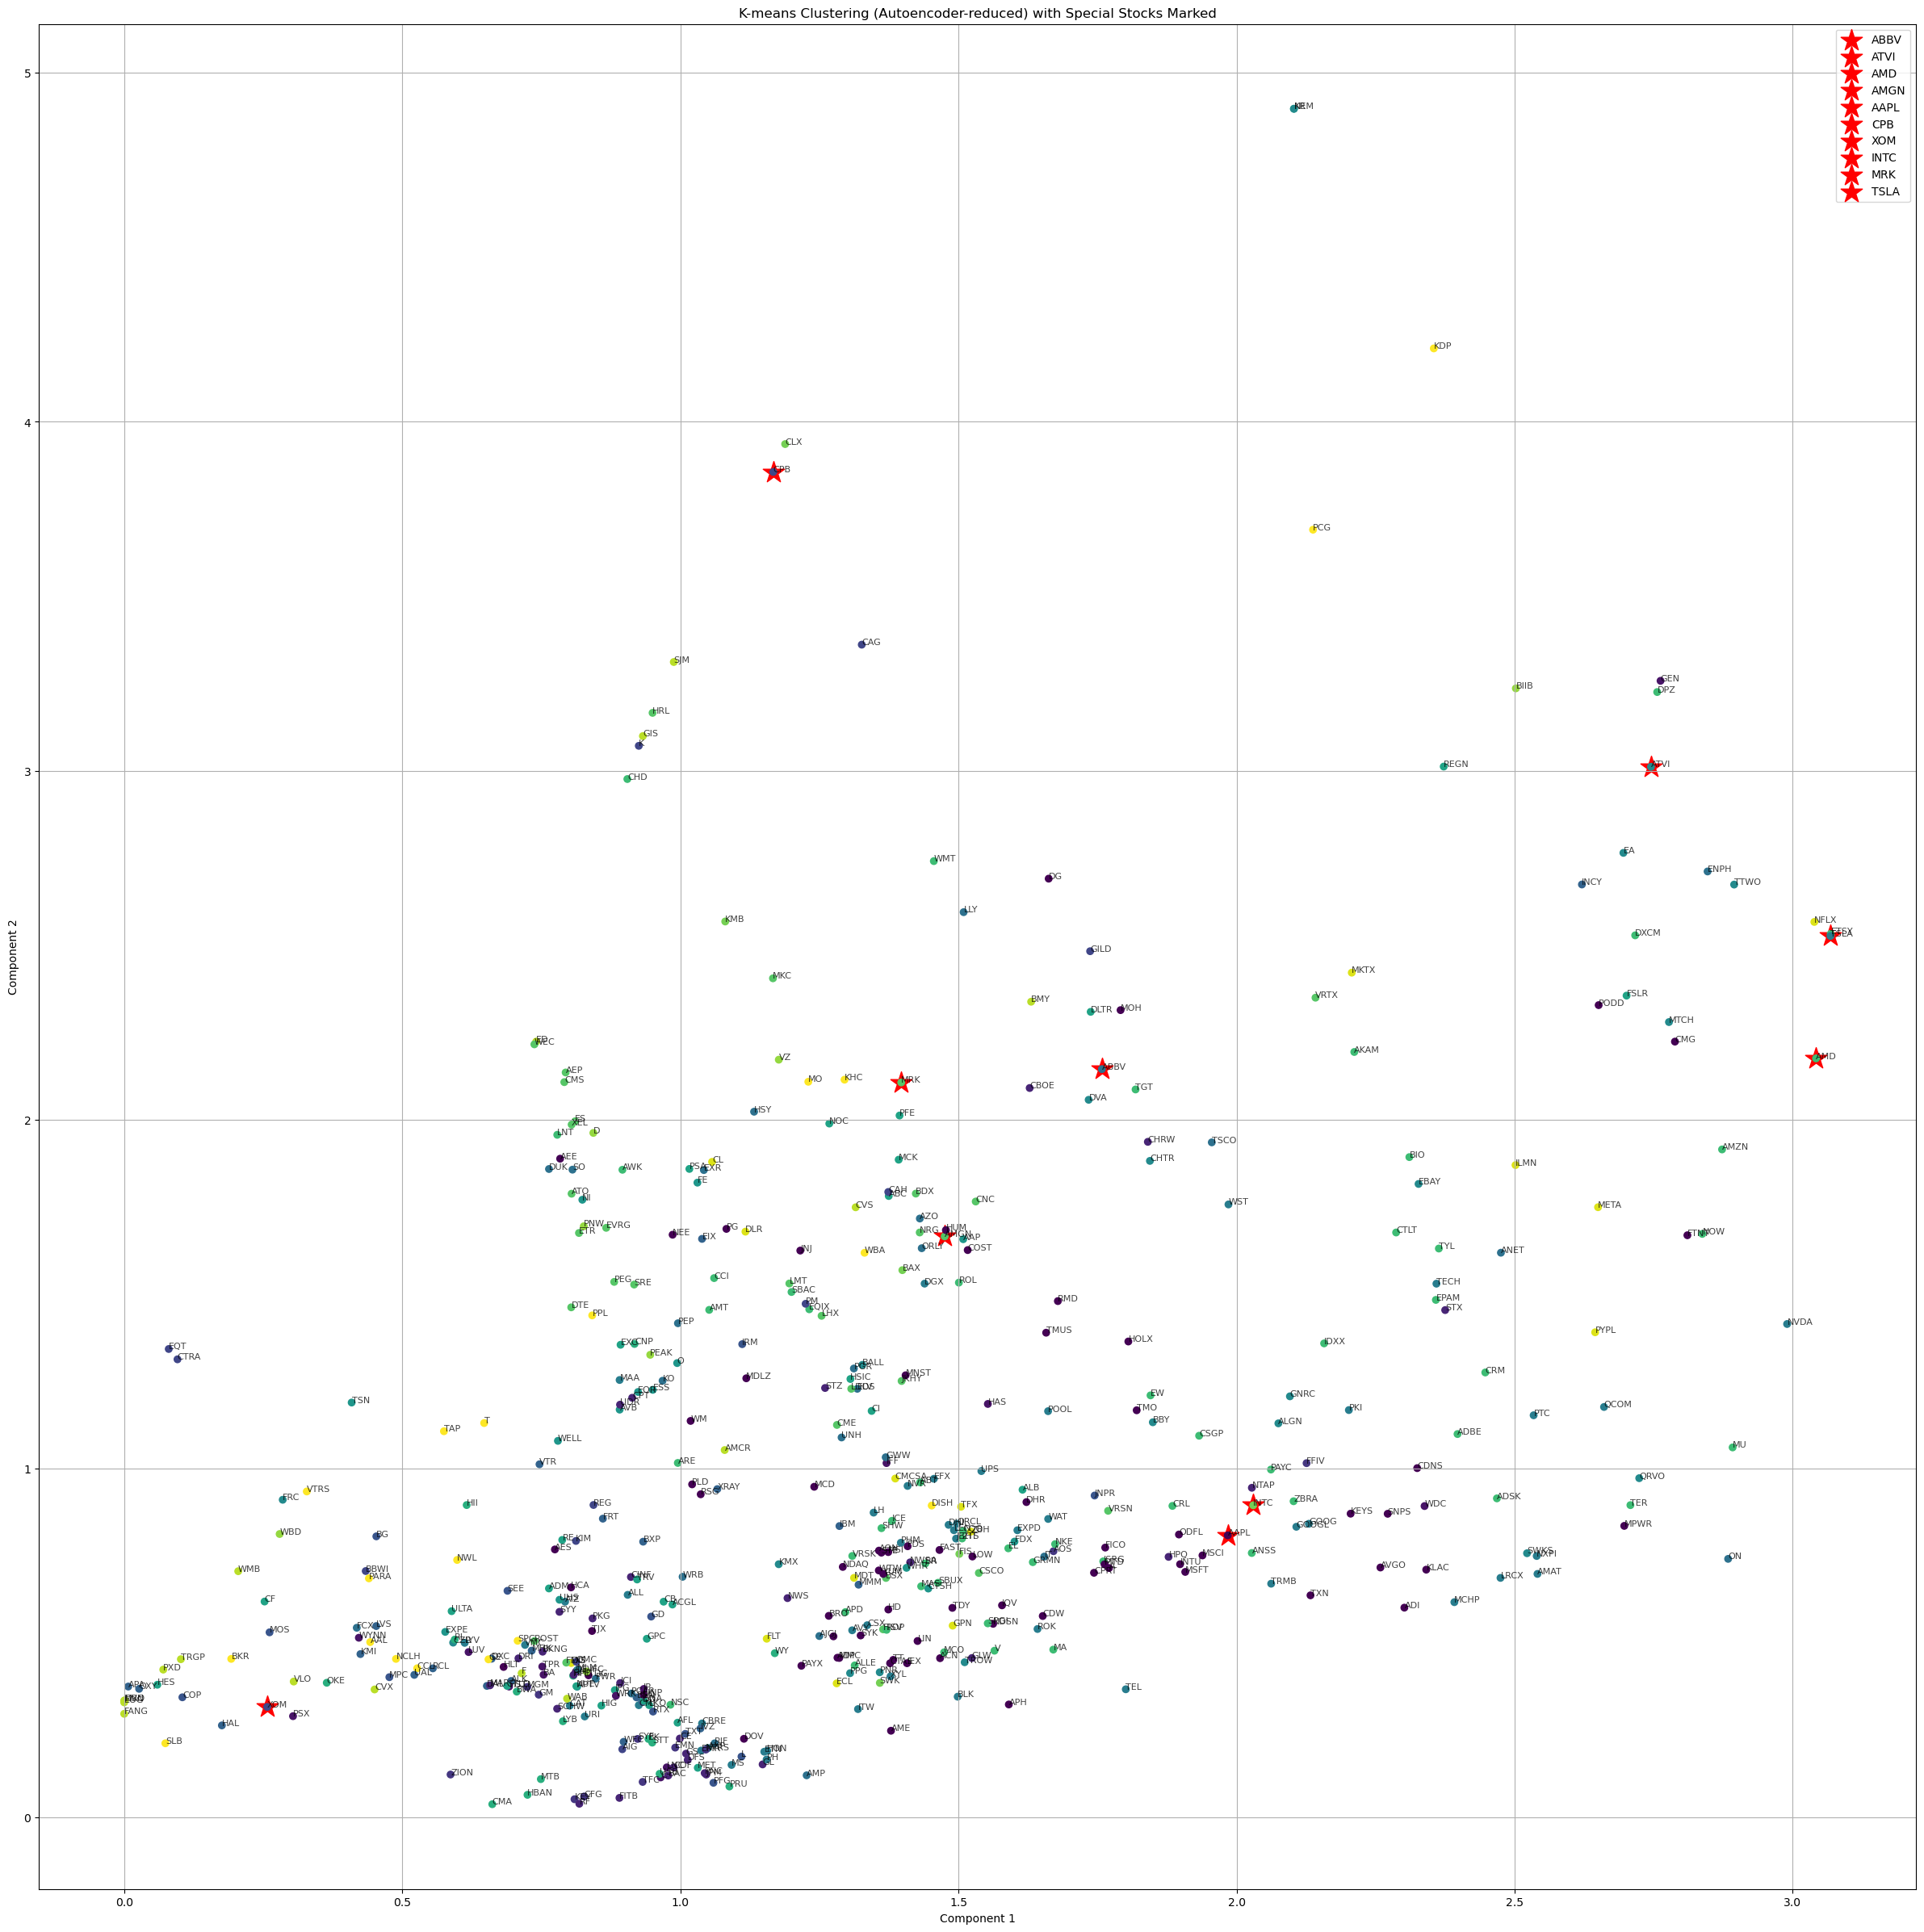

In [118]:
fig, ax = plt.subplots(figsize=(30, 30))
special_stocks = ['AAPL', 'TSLA', 'ABBV', 'MRK', 'ATVI', 'CPB', 'AMD', 'INTC', 'XOM', 'AMGN']

for i, stock in enumerate(sp500.columns):
    if stock in special_stocks:
        ax.scatter(reduced_data[i, 0], reduced_data[i, 1], c='r', marker='*', s=400, label=stock)

scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
stock_labels = sp500.columns
for i, stock in enumerate(stock_labels):
    ax.annotate(stock, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=8, alpha=0.75)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('K-means Clustering (Autoencoder-reduced) with Special Stocks Marked')
plt.legend()
plt.grid()
plt.show()

## Chinese Stock Market

In [42]:
def get_zz1000_list():
    
    def add_exchange_suffix(code):
        code_str = str(code)

        if len(code_str) == 4:
            code_str = '00' + code_str

        if code_str.startswith("6"):
            return code_str + ".ss"
        else:
            return code_str + ".sz"    
    
    file_path = "/Users/xiaoyanwang/Downloads/000852cons.xls"  
    df = pd.read_excel(file_path) 
    df.iloc[:, 4] = df.iloc[:, 4].apply(add_exchange_suffix)
    return df.iloc[:, 4]

zz1000_list = get_zz1000_list()
print(zz1000_list)

0      002100.sz
1      002190.sz
2      002302.sz
3      002254.sz
4      002405.sz
         ...    
995    002960.sz
996    688321.ss
997    002959.sz
998    603093.ss
999    688368.ss
Name: 成分券代码Constituent Code, Length: 1000, dtype: object


In [43]:
start_date='2016-01-01'
end_date='2023-04-30'
yf.download(zz1000_list[0], start=start_date, end=end_date, interval='1d', progress=False)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,10.10,10.15,9.10,9.12,8.113914,8020199
2016-01-05,8.80,9.26,8.57,9.01,8.016050,11226327
2016-01-06,9.08,9.23,8.96,9.19,8.176192,8409193
2016-01-07,9.07,9.08,8.52,8.52,7.580107,2557651
2016-01-08,9.00,9.02,8.30,8.84,7.864805,8490799
...,...,...,...,...,...,...
2023-04-24,8.95,8.99,8.70,8.76,8.760000,30956374
2023-04-25,8.78,8.85,8.60,8.76,8.760000,29113677
2023-04-26,8.70,8.97,8.65,8.79,8.790000,29708279
